In [37]:
import ee
import geopandas as gpd
from src.data.ee import mtbs, ee_utils
from src.visualization import ee_viz
from src.data import shape_processor, gedi_pipeline
from src.visualization import gedi_viz
import matplotlib.pyplot as plt
from src.data.ee import landsat_import

from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB

import seaborn as sns
sns.set_theme()

import importlib
importlib.reload(gedi_pipeline)
importlib.reload(gedi_viz)
importlib.reload(ee_utils)

2023-09-09 19:45:18,487 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-09-09 19:45:18,491 DEBUG: Logger /home/jk871/fire-regen/src/data/ee/ee_utils.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


<module 'src.data.ee.ee_utils' from '/home/jk871/fire-regen/src/data/ee/ee_utils.py'>

In [20]:
ee.Authenticate()


Successfully saved authorization token.


In [3]:
ee.Initialize()

In [4]:
sierras = gpd.read_file("../../../data/shapefiles/sierras_convex_hull.shp")

firep_db = FirePerimetersDB('../../../data/fire_perimeters.gdb/')
sierra_firep = FirePerimeters(firep_db).filter_for_years(['1992']).filter_within_geometry(sierras)

In [5]:
fire = sierra_firep.get_fire('RAINBOW')

In [13]:
fire.get().geometry.explore()

In [1]:
fire.fire

NameError: name 'fire' is not defined

In [6]:
fire_as_one = shape_processor.get_union(fire.fire, 4326)

### Get MTBS severity data

In [7]:
burn_severity_ic = mtbs.get_burn_severity_data().sort('system:time_start', False).filterDate('1992', '1993')

In [8]:
fire_severity = burn_severity_ic.filterBounds(ee_utils.gdf_to_ee_polygon(fire_as_one.geometry.iloc[0])).first()

In [46]:
ee_viz.viz_burn_severity(fire_severity, fire_as_one.geometry.iloc[0], ['burn_severity'])

Map(center=[37.59361359526492, -119.08474625808235], controls=(WidgetControl(options=['position', 'transparent…

### Get Landsat data

In [26]:
fire_landsat_5 = landsat_import.get_landsat_5(fire_as_one.geometry[0], str(1991)).select('NDVI').rename('NDVI_1991')
for year in range(1992, 1999):
    new_ls = landsat_import.get_landsat_5(fire_as_one.geometry[0], str(year)).select('NDVI').rename(f'NDVI_{year}')
    fire_landsat_5 = fire_landsat_5.addBands(new_ls)

In [ ]:
ee_viz.viz_burn_severity(fire_landsat_5, fire_as_one.geometry.iloc[0], ['NDVI_1991', 'NDVI_1993', 'NDVI_2001', 'NDVI_2022'])

In [29]:
fire_landsat_7 = landsat_import.get_landsat_7(fire_as_one.geometry[0], str(1999)).select('NDVI').rename('NDVI_1999')
for year in range(2000, 2013):
    new_ls = landsat_import.get_landsat_7(fire_as_one.geometry[0], str(year)).select('NDVI').rename(f'NDVI_{year}')
    fire_landsat_7 = fire_landsat_7.addBands(new_ls)

In [30]:
fire_landsat_8 = landsat_import.get_landsat_8(fire_as_one.geometry[0], str(2013)).select('NDVI').rename('NDVI_2013')
for year in range(2014, 2023):
    new_ls = landsat_import.get_landsat_8(fire_as_one.geometry[0], str(year)).select('NDVI').rename(f'NDVI_{year}')
    fire_landsat_8 = fire_landsat_8.addBands(new_ls)

In [35]:
fire_data_ls_5 = ee.ImageCollection([fire_landsat_5]).getRegion(ee_utils.gdf_to_ee_polygon(fire_as_one.geometry[0]), 30).getInfo()
fire_data_ls_7 = ee.ImageCollection([fire_landsat_7]).getRegion(ee_utils.gdf_to_ee_polygon(fire_as_one.geometry[0]), 30).getInfo()
fire_data_ls_8 = ee.ImageCollection([fire_landsat_8]).getRegion(ee_utils.gdf_to_ee_polygon(fire_as_one.geometry[0]), 30).getInfo()
fire_data_severity = ee.ImageCollection([fire_severity]).getRegion(ee_utils.gdf_to_ee_polygon(fire_as_one.geometry[0]), 30).getInfo()

In [50]:
pdf_ls_5 = ee_utils.ee_array_to_df_without_time(fire_data_ls_5, [f"NDVI_{year}" for year in range(1991, 1999)]).set_index(["latitude", "longitude"])
pdf_ls_7 = ee_utils.ee_array_to_df_without_time(fire_data_ls_7, [f"NDVI_{year}" for year in range(1999, 2013)]).set_index(["latitude", "longitude"])
pdf_ls_8 = ee_utils.ee_array_to_df_without_time(fire_data_ls_8, [f"NDVI_{year}" for year in range(2013, 2023)]).set_index(["latitude", "longitude"])
pdf_severity = ee_utils.ee_array_to_df_without_time(fire_data_severity, ["burn_severity"]).set_index(["latitude", "longitude"])

In [85]:
pdf_all = pd.concat([pdf_ls_5, pdf_ls_7, pdf_ls_8, pdf_severity], axis=1).reset_index()

In [86]:
pdf_all = pdf_all.dropna()

In [88]:
for year in range(1991, 2023):
    pdf_all.rename(columns={f"NDVI_{year}": year-1992}, inplace=True)

In [89]:
pdf_all

,latitude,longitude,-1,0,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,burn_severity
0,37.545581,-119.087097,0.730256,0.679380,0.709906,0.697192,0.678940,0.715540,0.726859,0.763987,...,0.846185,0.863064,0.838980,0.827943,0.837410,0.838555,0.839800,0.720986,0.722862,1.0
3,37.545851,-119.090331,0.629204,0.539539,0.570132,0.541450,0.643499,0.601374,0.633314,0.695541,...,0.674905,0.697052,0.681366,0.751063,0.705692,0.745836,0.685674,0.534212,0.698273,2.0
4,37.545851,-119.090061,0.585758,0.529057,0.557847,0.510340,0.620763,0.621540,0.636789,0.714859,...,0.573485,0.551247,0.580394,0.692097,0.594565,0.698420,0.605347,0.483864,0.631692,1.0
5,37.545851,-119.089792,0.651829,0.573450,0.618025,0.560917,0.653865,0.657122,0.659216,0.729484,...,0.688095,0.701037,0.667592,0.747439,0.692879,0.734841,0.668040,0.557784,0.724708,2.0
6,37.545851,-119.089522,0.702290,0.642097,0.661573,0.639374,0.677135,0.710944,0.731167,0.761405,...,0.748949,0.744449,0.701742,0.750899,0.712433,0.734415,0.696393,0.518309,0.702553,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47507,37.639365,-119.062843,0.557303,0.517003,0.551503,0.515968,0.480154,0.545016,0.546722,0.596212,...,0.672593,0.671248,0.685109,0.541298,0.667865,0.670791,0.663348,0.660666,0.643527,1.0
47508,37.639365,-119.062573,0.547486,0.504475,0.523532,0.512114,0.491597,0.558628,0.542281,0.622880,...,0.662721,0.645511,0.706836,0.542055,0.675345,0.686594,0.681270,0.649100,0.610781,1.0
47509,37.639635,-119.063112,0.436053,0.426117,0.418197,0.439430,0.399092,0.501790,0.462106,0.500513,...,0.547971,0.550712,0.558233,0.441220,0.528698,0.546437,0.495397,0.506179,0.524838,1.0
47510,37.639635,-119.062843,0.476524,0.463518,0.492355,0.461911,0.428173,0.508108,0.491568,0.546460,...,0.579604,0.599019,0.615965,0.597561,0.595946,0.620872,0.607105,0.588475,0.587500,1.0


In [90]:
pdf_melt = pd.melt(pdf_all, id_vars=["burn_severity", "latitude", "longitude"], value_vars=[year - 1992 for year in range(1991, 2023)]).rename(columns={0:"variable"})

In [91]:
pdf_melt

,burn_severity,latitude,longitude,variable,value
0,1.0,37.545581,-119.087097,-1,0.730256
1,2.0,37.545851,-119.090331,-1,0.629204
2,1.0,37.545851,-119.090061,-1,0.585758
3,2.0,37.545851,-119.089792,-1,0.651829
4,2.0,37.545851,-119.089522,-1,0.702290
...,...,...,...,...,...
1364475,1.0,37.639365,-119.062843,30,0.643527
1364476,1.0,37.639365,-119.062573,30,0.610781
1364477,1.0,37.639635,-119.063112,30,0.524838
1364478,1.0,37.639635,-119.062843,30,0.587500


<Axes: xlabel='variable', ylabel='value'>

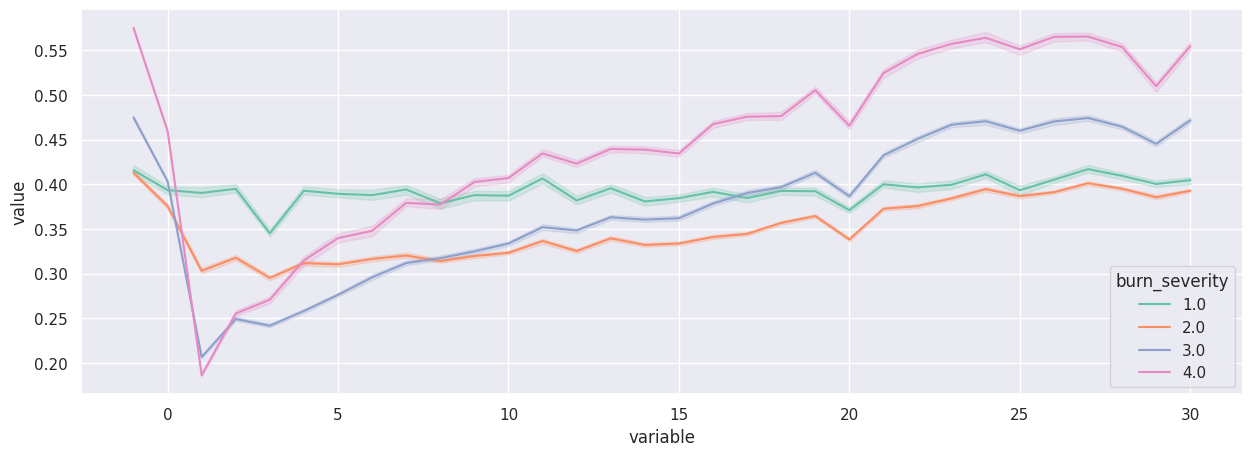

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.lineplot(pdf_melt[pdf_melt.burn_severity.isin([1, 2, 3, 4])], x="variable", y="value", hue="burn_severity", ax=ax, palette="Set2", estimator="median")
#ax.set_ylabel("NDVI", fontsize=20)
#ax.set_xlabel("Year", fontsize=20)
#ax.tick_params(axis="both", labelsize=12)
#ax.axvline('0', color="red", linestyle='--')
#ax.legend(title='Fire Year')

<Axes: xlabel='variable', ylabel='value'>

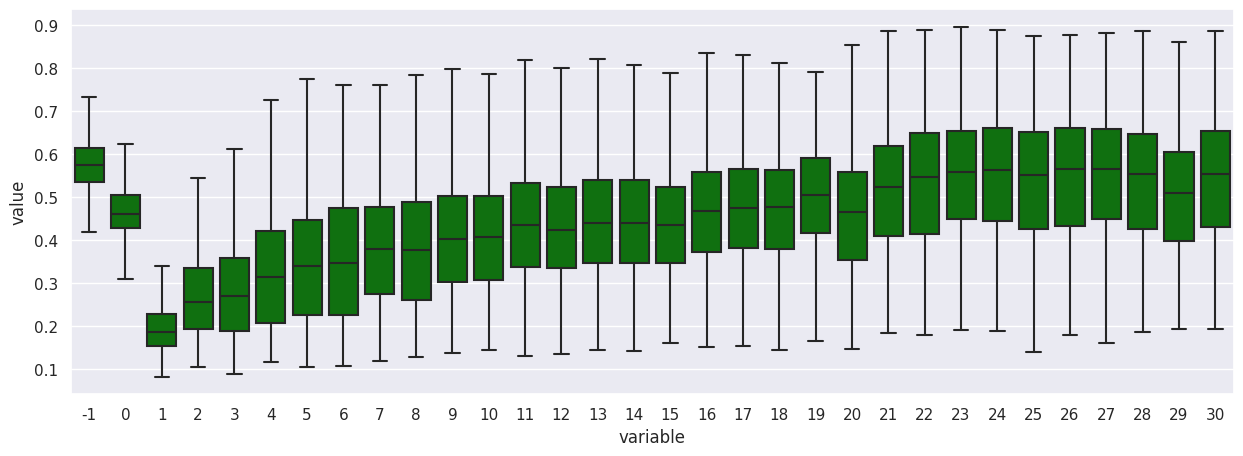

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.boxplot(pdf_melt[pdf_melt.burn_severity.isin([4])], x="variable", y="value", color="green", ax=ax, showfliers=False)

In [105]:
palette = sns.color_palette("Paired")
palette

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

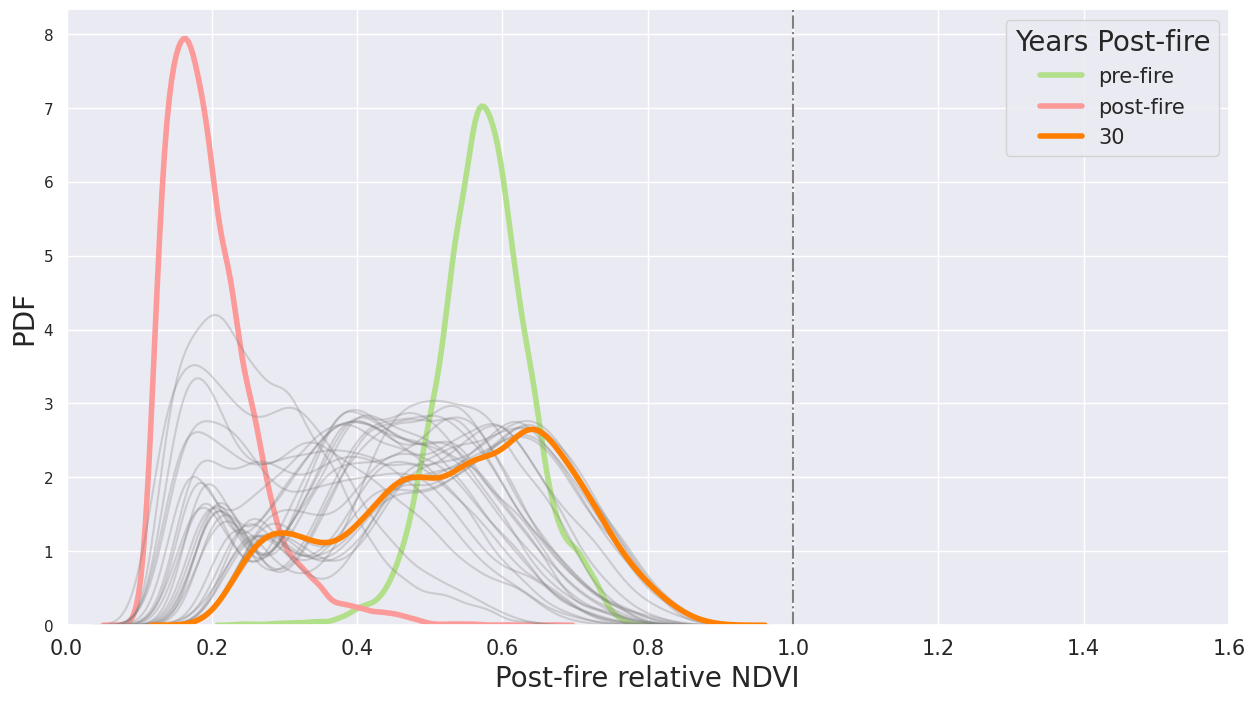

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
to_plot = pdf_all[pdf_all.burn_severity.isin([4])]
sns.kdeplot(to_plot, x=-1, linewidth=4, label="pre-fire", legend=True, color=palette[2])
sns.kdeplot(to_plot, x=1, linewidth=4, label="post-fire", legend=True, color=palette[4])

for i in range(2, 30):
    sns.kdeplot(to_plot, x=i, alpha=0.3, color="gray", label='_nolegend_')
sns.kdeplot(to_plot, x=30, linewidth=4, label="30", legend=True, color=palette[7])
ax.set_xlim((0, 1.6))
ax.set_xlabel("Post-fire relative NDVI", fontsize=20)
ax.set_ylabel("PDF", fontsize=20)
ax.axvline(x=1, linestyle="-.", color="gray")
plt.legend()
ax.legend(title="Years Post-fire", fontsize=15, title_fontsize=20)
ax.tick_params(axis='x', which='major', labelsize=15)

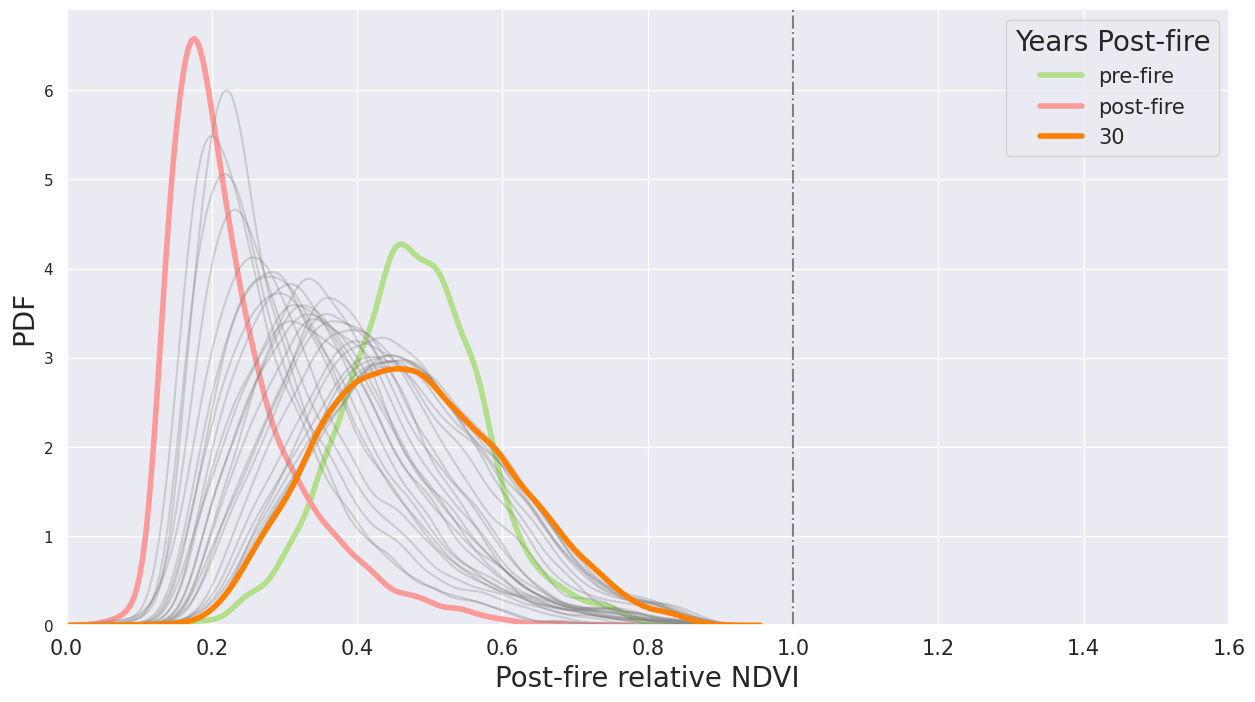

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
to_plot = pdf_all[pdf_all.burn_severity.isin([3])]
sns.kdeplot(to_plot, x=-1, linewidth=4, label="pre-fire", legend=True, color=palette[2])
sns.kdeplot(to_plot, x=1, linewidth=4, label="post-fire", legend=True, color=palette[4])

for i in range(2, 30):
    sns.kdeplot(to_plot, x=i, alpha=0.3, color="gray", label='_nolegend_')
sns.kdeplot(to_plot, x=30, linewidth=4, label="30", legend=True, color=palette[7])
ax.set_xlim((0, 1.6))
ax.set_xlabel("Post-fire relative NDVI", fontsize=20)
ax.set_ylabel("PDF", fontsize=20)
ax.axvline(x=1, linestyle="-.", color="gray")
plt.legend()
ax.legend(title="Years Post-fire", fontsize=15, title_fontsize=20)
ax.tick_params(axis='x', which='major', labelsize=15)

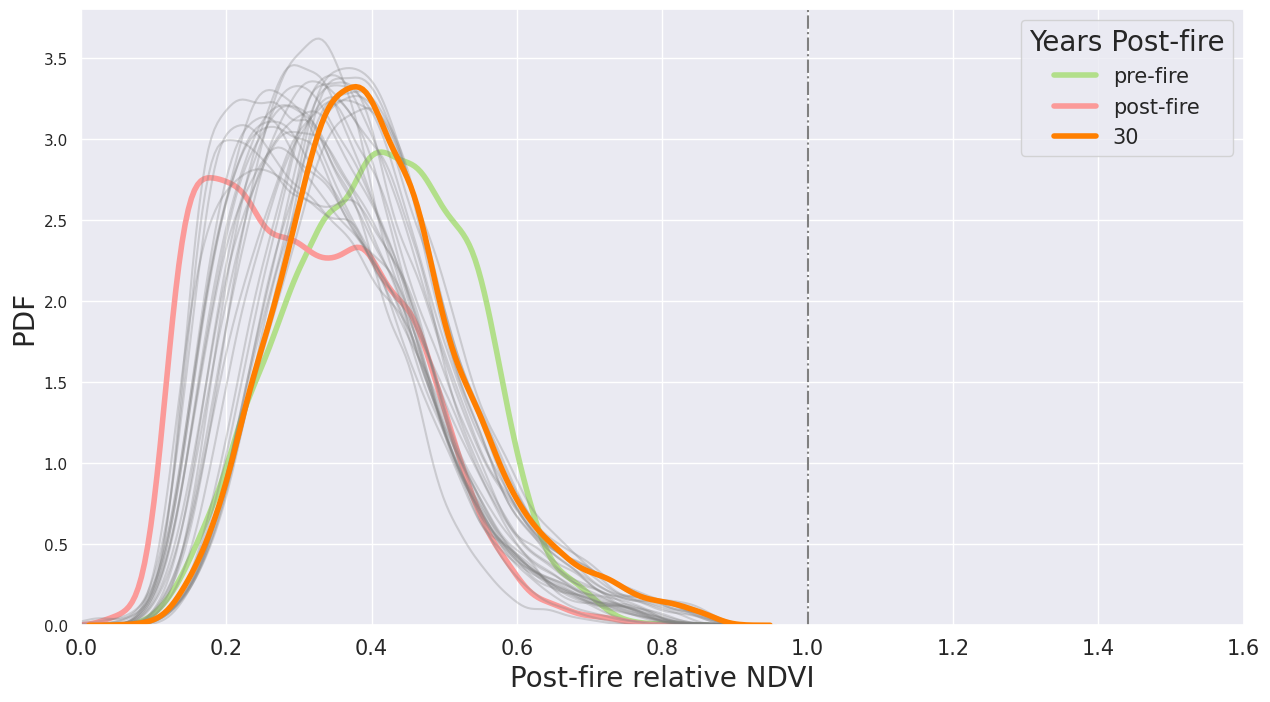

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
to_plot = pdf_all[pdf_all.burn_severity.isin([2])]
sns.kdeplot(to_plot, x=-1, linewidth=4, label="pre-fire", legend=True, color=palette[2])
sns.kdeplot(to_plot, x=1, linewidth=4, label="post-fire", legend=True, color=palette[4])

for i in range(2, 30):
    sns.kdeplot(to_plot, x=i, alpha=0.3, color="gray", label='_nolegend_')
sns.kdeplot(to_plot, x=30, linewidth=4, label="30", legend=True, color=palette[7])
ax.set_xlim((0, 1.6))
ax.set_xlabel("Post-fire relative NDVI", fontsize=20)
ax.set_ylabel("PDF", fontsize=20)
ax.axvline(x=1, linestyle="-.", color="gray")
plt.legend()
ax.legend(title="Years Post-fire", fontsize=15, title_fontsize=20)
ax.tick_params(axis='x', which='major', labelsize=15)

<Axes: xlabel='variable', ylabel='value'>

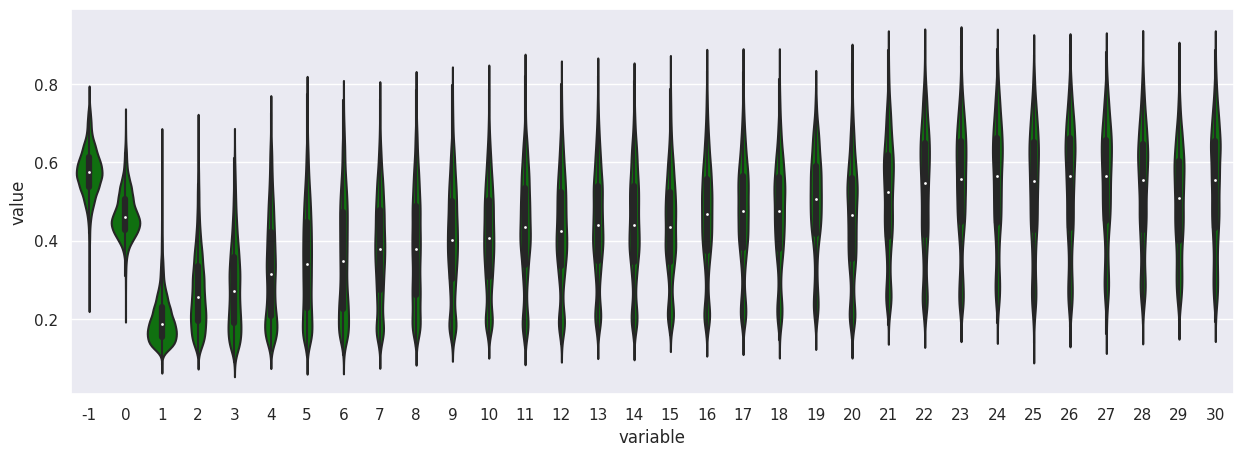

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.violinplot(pdf_melt[pdf_melt.burn_severity.isin([4])], x="variable", y="value", color="green", ax=ax, showfliers=False)

### Get GEDI data

In [52]:
gedi_all = gedi_pipeline.load_stage_2()

In [53]:
gedi_fire = gedi_all.sjoin(fire.fire, how="inner", predicate="within")

In [54]:
gedi_fire

,shot_number,longitude,latitude,agbd,agbd_pi_lower,agbd_pi_upper,agbd_se,beam_type,sensitivity,pft_class,...,REPORT_AC,GIS_ACRES,C_METHOD,OBJECTIVE,FIRE_NUM,Shape_Length,Shape_Area,COMPLEX_NAME,COMPLEX_INCNUM,FID
18852588,87140600200403840,-119.098537,37.552951,138.259979,39.382938,297.259613,11.100622,full,0.983941,1,...,8800.0,8358.355469,8.0,1.0,00000087,36888.596258,3.382506e+07,NaN,NaN,0
18852589,87140600200403842,-119.097522,37.553634,24.664406,-9999.000000,109.218582,11.107200,full,0.974373,1,...,8800.0,8358.355469,8.0,1.0,00000087,36888.596258,3.382506e+07,NaN,NaN,0
18852613,175280200200124666,-119.099991,37.553215,123.284462,31.593378,275.092377,11.099557,coverage,0.955555,1,...,8800.0,8358.355469,8.0,1.0,00000087,36888.596258,3.382506e+07,NaN,NaN,0
18891169,204920500300287270,-119.082449,37.548131,59.603413,5.005670,174.327499,11.101315,full,0.983028,1,...,8800.0,8358.355469,8.0,1.0,00000087,36888.596258,3.382506e+07,NaN,NaN,0
18891175,204920600300529330,-119.091129,37.546909,17.458380,-9999.000000,93.389320,11.111454,full,0.950840,1,...,8800.0,8358.355469,8.0,1.0,00000087,36888.596258,3.382506e+07,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19891586,222730600200404133,-119.068578,37.594273,170.484909,102.533539,255.618988,3.108198,full,0.962374,6,...,8800.0,8358.355469,8.0,1.0,00000087,36888.596258,3.382506e+07,NaN,NaN,0
19891587,222730600200404134,-119.068086,37.594608,141.414322,80.573097,219.256104,3.075245,full,0.953960,6,...,8800.0,8358.355469,8.0,1.0,00000087,36888.596258,3.382506e+07,NaN,NaN,0
19891588,222730600200404135,-119.067594,37.594943,110.104332,57.657009,179.369781,3.042248,full,0.958405,6,...,8800.0,8358.355469,8.0,1.0,00000087,36888.596258,3.382506e+07,NaN,NaN,0
19891589,222730600200404136,-119.067102,37.595277,161.882950,95.979500,244.914108,3.098254,full,0.956522,6,...,8800.0,8358.355469,8.0,1.0,00000087,36888.596258,3.382506e+07,NaN,NaN,0


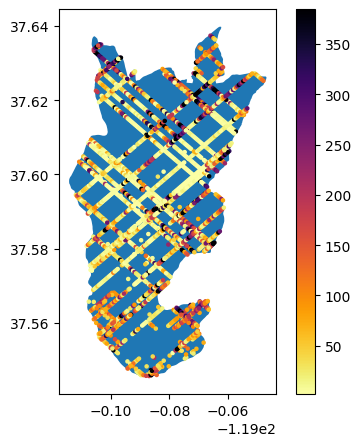

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

fire.fire.plot(ax=ax)
geo_plot(gedi_fire, ax, 'agbd')

### Get Existing GEDI pipeline data

In [65]:
gedi_burned, gedi_unburned = gedi_pipeline.load_stage_6(2)

In [66]:
gedi_fire = gedi_burned.sjoin(fire.fire, how="inner", predicate="within")

In [67]:
gedi_fire

,shot_number,longitude,latitude,agbd,agbd_pi_lower,agbd_pi_upper,agbd_se,beam_type,sensitivity,pft_class,...,REPORT_AC,GIS_ACRES,C_METHOD,OBJECTIVE,FIRE_NUM,Shape_Length,Shape_Area,COMPLEX_NAME,COMPLEX_INCNUM,FID
19754681,212661100200120403,-119.105373,37.575250,53.846088,19.902203,104.341949,2.994101,full,0.956687,6,...,8800.0,8358.355469,8.0,1.0,00000087,36888.596258,3.382506e+07,NaN,NaN,0
19754741,222730500200120631,-119.107010,37.575449,2.240774,-9999.000000,19.158796,3.001085,full,0.975634,6,...,8800.0,8358.355469,8.0,1.0,00000087,36888.596258,3.382506e+07,NaN,NaN,0
19754747,222730500200120637,-119.104075,37.577440,12.515764,0.443020,41.087166,2.984458,full,0.961889,6,...,8800.0,8358.355469,8.0,1.0,00000087,36888.596258,3.382506e+07,NaN,NaN,0
19754765,46871100200120464,-119.106369,37.574064,2.221455,-9999.000000,19.102547,3.001162,full,0.967670,6,...,8800.0,8358.355469,8.0,1.0,00000087,36888.596258,3.382506e+07,NaN,NaN,0
19777830,212660800200124140,-119.107222,37.581345,68.909775,29.367605,125.063828,3.004938,full,0.962608,6,...,8800.0,8358.355469,8.0,1.0,00000087,36888.596258,3.382506e+07,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19891537,212661100200120462,-119.075534,37.595492,15.964723,1.263851,47.155201,2.982821,full,0.973573,6,...,8800.0,8358.355469,8.0,1.0,00000087,36888.596258,3.382506e+07,NaN,NaN,0
19891538,212661100200120463,-119.075048,37.595821,18.489573,2.041736,51.423347,2.982156,full,0.972841,6,...,8800.0,8358.355469,8.0,1.0,00000087,36888.596258,3.382506e+07,NaN,NaN,0
19891539,212661100200120464,-119.074547,37.596163,8.148240,-9999.000000,32.816154,2.988328,full,0.974157,6,...,8800.0,8358.355469,8.0,1.0,00000087,36888.596258,3.382506e+07,NaN,NaN,0
19891540,212661100200120465,-119.074049,37.596501,1.996079,-9999.000000,18.433859,3.002097,full,0.974801,6,...,8800.0,8358.355469,8.0,1.0,00000087,36888.596258,3.382506e+07,NaN,NaN,0


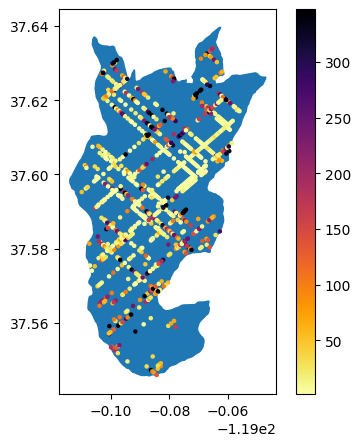

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

fire.fire.plot(ax=ax)
geo_plot(gedi_fire, ax, 'agbd')

In [71]:
gedi_fire.columns

Index(['shot_number', 'longitude', 'latitude', 'agbd', 'agbd_pi_lower',
       'agbd_pi_upper', 'agbd_se', 'beam_type', 'sensitivity', 'pft_class',
       'gedi_year', 'gedi_month', 'absolute_time', 'geometry', 'severity',
       'burn_year', 'burn_count', 'time_since_burn', 'land_cover_3x3',
       'land_cover_mean', 'land_cover_std', 'land_cover_median', 'index_right',
       'YEAR_', 'STATE', 'AGENCY', 'UNIT_ID', 'FIRE_NAME', 'INC_NUM',
       'ALARM_DATE', 'CONT_DATE', 'CAUSE', 'COMMENTS', 'REPORT_AC',
       'GIS_ACRES', 'C_METHOD', 'OBJECTIVE', 'FIRE_NUM', 'Shape_Length',
       'Shape_Area', 'COMPLEX_NAME', 'COMPLEX_INCNUM', 'FID'],
      dtype='object')

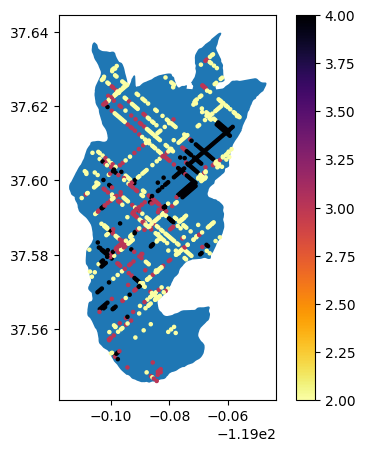

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

fire.fire.plot(ax=ax)
geo_plot(gedi_fire, ax, 'severity')

(0.0, 700.0)

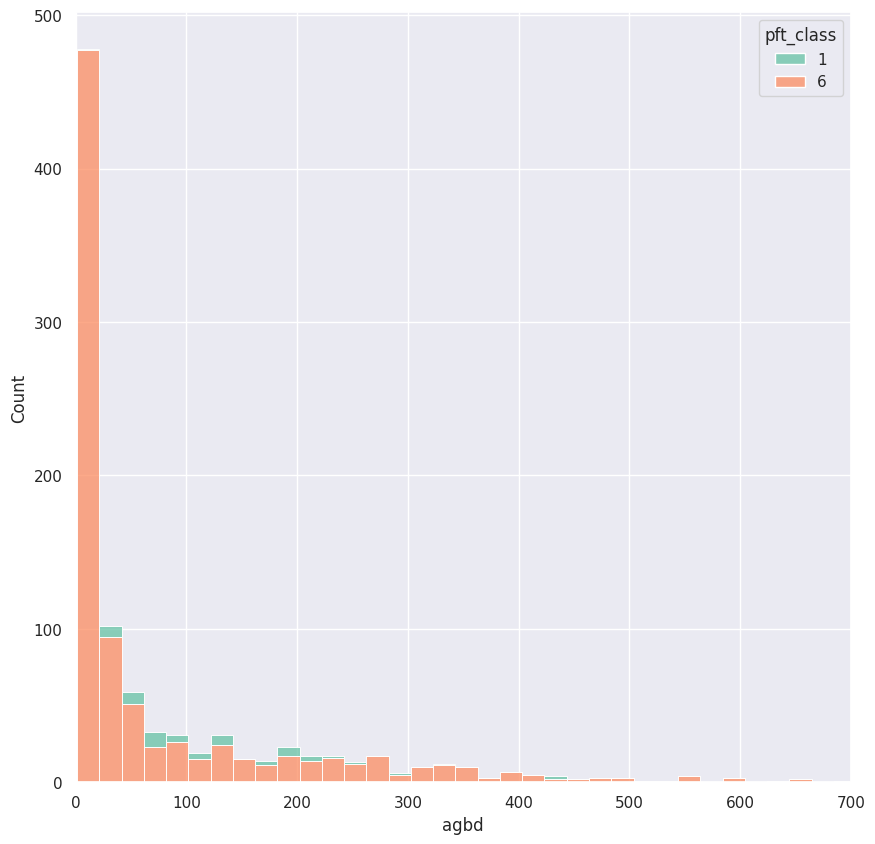

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
sns.histplot(gedi_fire, x='agbd', ax=ax, hue='pft_class', multiple='stack', palette='Set2')
ax.set_xlim((0, 700))

(0.0, 700.0)

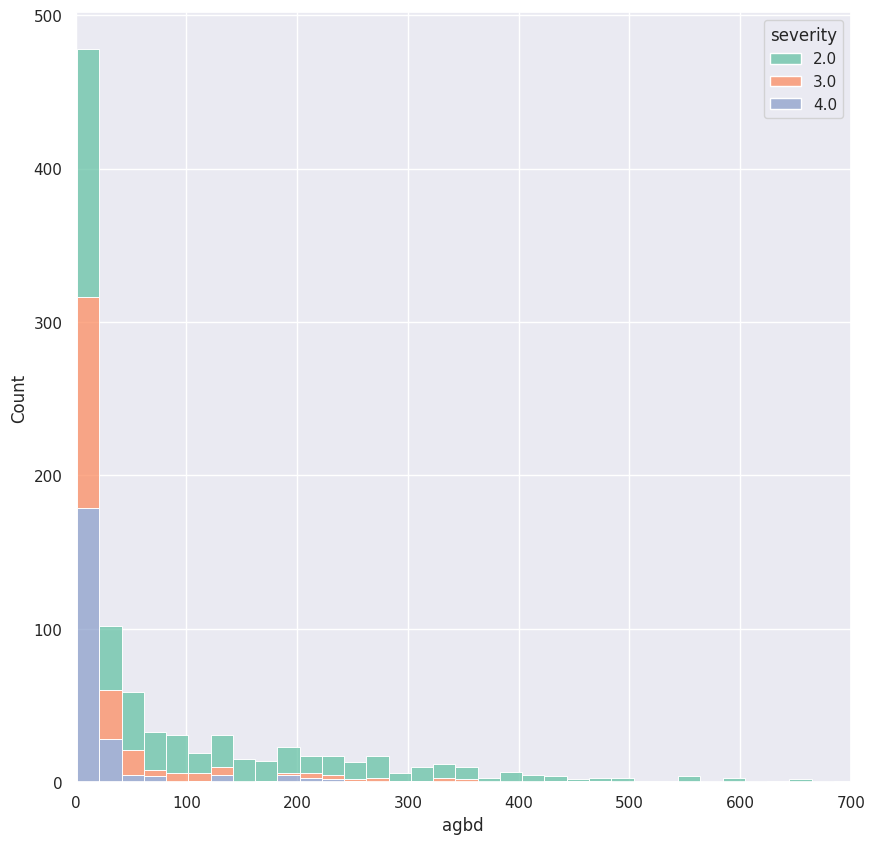

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
sns.histplot(gedi_fire, x='agbd', ax=ax, hue='severity', multiple='stack', palette='Set2')
ax.set_xlim((0, 700))

(0.0, 600.0)

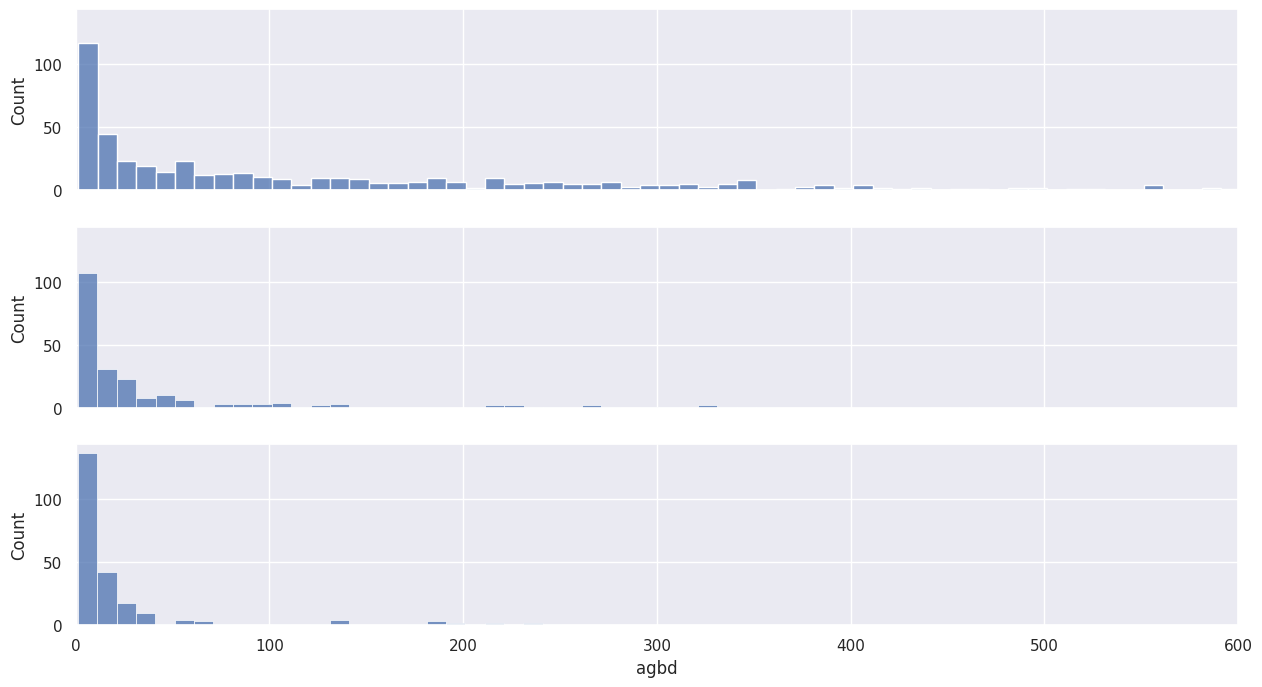

In [92]:
fig, ax = plt.subplots(3, 1, figsize=(15,8), sharex=True, sharey=True)
sns.histplot(gedi_fire[gedi_fire.severity==2], x='agbd', ax=ax[0], palette='Set2', binwidth=10)
sns.histplot(gedi_fire[gedi_fire.severity==3], x='agbd', ax=ax[1], palette='Set2', binwidth=10)
sns.histplot(gedi_fire[gedi_fire.severity==4], x='agbd', ax=ax[2], palette='Set2', binwidth=10)

ax[0].set_xlim((0, 600))

<Axes: >

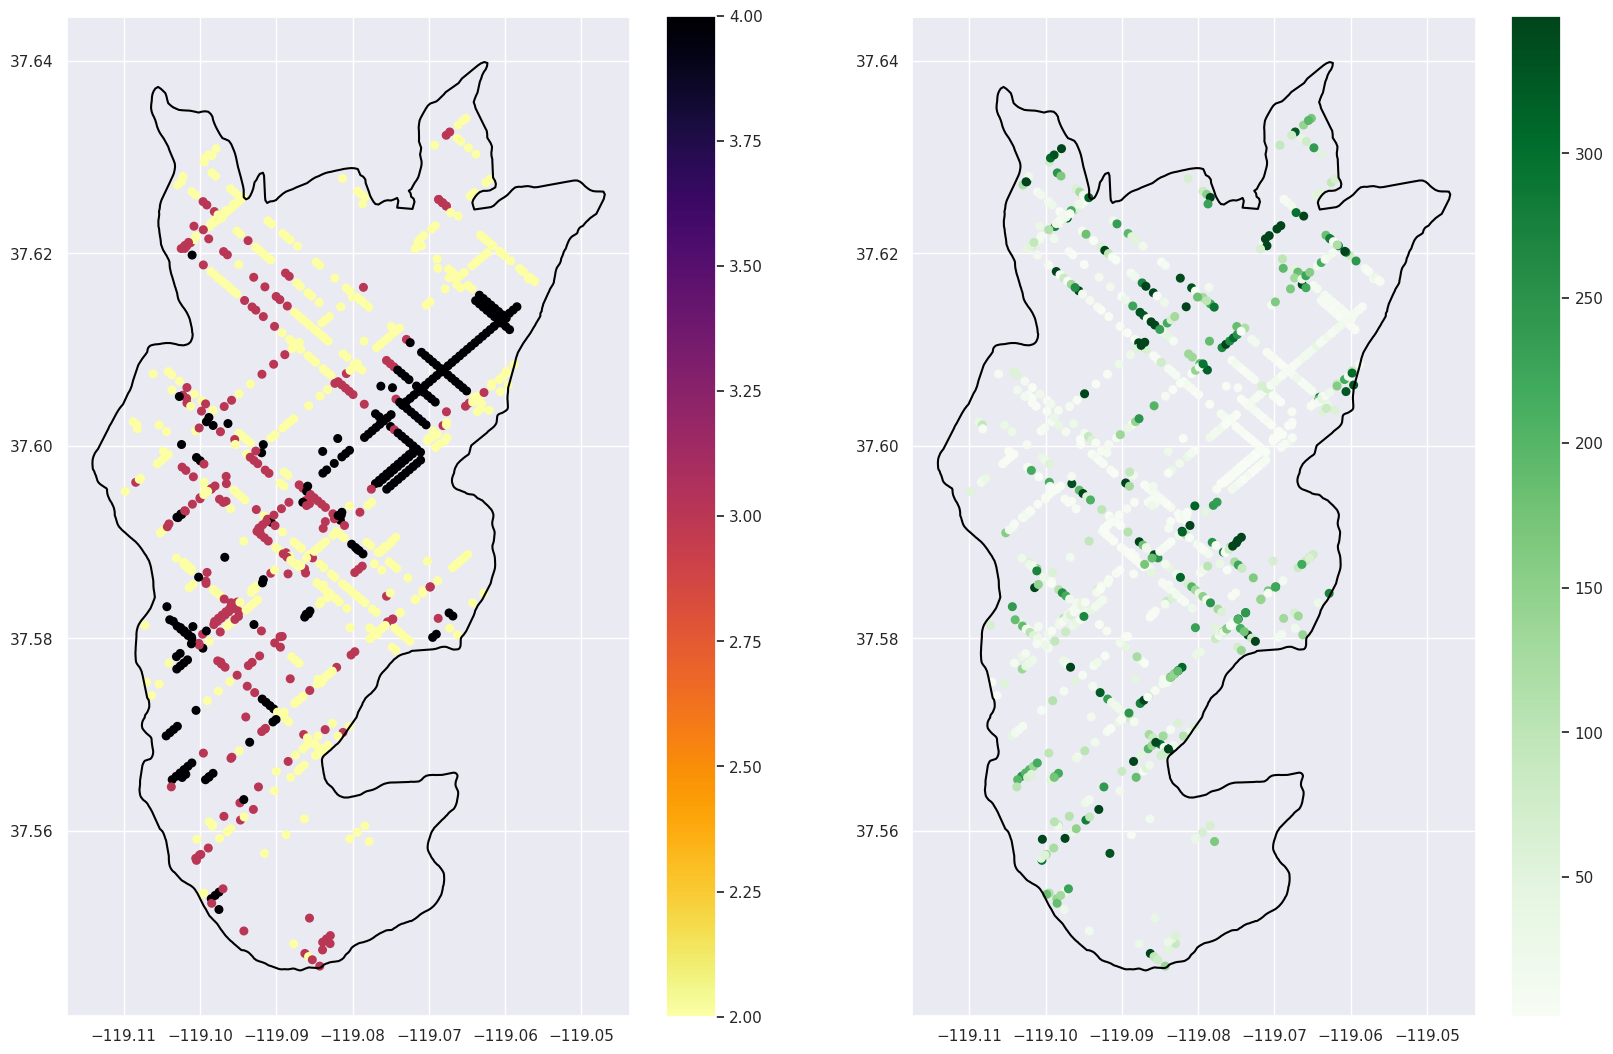

In [102]:
fig, ax = plt.subplots(1, 2, figsize=(20, 13))

gedi_viz.geo_plot(gedi_fire, ax[0], 'severity', markersize=30)
gedi_viz.geo_plot(gedi_fire, ax[1], 'agbd', cmap='Greens', markersize=30)
fire.fire.boundary.plot(ax=ax[0], color='black')
fire.fire.boundary.plot(ax=ax[1], color='black')

<Axes: xlabel='severity', ylabel='agbd'>

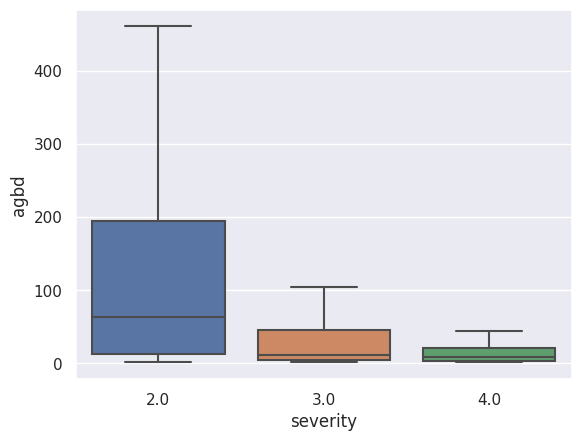

In [104]:
sns.boxplot(gedi_fire, x="severity", y="agbd", showfliers=False)

### Obtain NDVI